In [1]:
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import six
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import round
import pandas as pd

In [2]:
#Inicializamos la sesion de Spark
spark = SparkSession \
    .builder \
    .config('spark.sql.debug.maxToStringFields', 2000) \
    .getOrCreate()

In [3]:
#Lectura del archivo .parquet
df = spark.read.parquet('/LUSTRE/home/mcd-01/dataset.parquet')

### Exploración de Datos

Schema de nuestro conjunto de datos

In [4]:
df.cache()
df.printSchema()

root
 |-- XLAT: double (nullable = true)
 |-- XLONG: double (nullable = true)
 |-- LU_INDEX: double (nullable = true)
 |-- VAR_SSO: double (nullable = true)
 |-- MU: double (nullable = true)
 |-- MUB: double (nullable = true)
 |-- Q2: double (nullable = true)
 |-- T2: double (nullable = true)
 |-- TH2: double (nullable = true)
 |-- PSFC: double (nullable = true)
 |-- U10: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- TOPOSLPX: double (nullable = true)
 |-- TOPOSLPY: double (nullable = true)
 |-- SHDMAX: double (nullable = true)
 |-- SHDMIN: double (nullable = true)
 |-- SNOALB: double (nullable = true)
 |-- SEAICE: double (nullable = true)
 |-- IVGTYP: double (nullable = true)
 |-- ISLTYP: double (nullable = true)
 |-- VEGFRA: double (nullable = true)
 |-- SNOW: double (nullable = true)
 |-- SNOWH: double (nullable = true)
 |-- CANWAT: double (nullable = true)
 |-- LAKE_DEPTH: double (nullable = true)
 |-- UOCE: double (nullable = true)
 |-- VOCE: double (nullable = 

In [5]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
XLAT,106218,24.034976501572274,8.670468176868019,8.225723,39.51725
XLONG,106218,-101.34100341677488,12.977148743656336,-126.501343,-76.180664
LU_INDEX,106218,13.106215519026907,5.140676772032896,1.0,17.0
VAR_SSO,106218,401.98499389380385,1283.3207106221182,0.0,23457.728516
MU,106218,1810.8443963735126,781.9099183325786,569.960938,3451.492188
MUB,106218,91341.6215316313,6807.606878952749,59051.03125,96245.40625
Q2,106218,0.009804539654295886,0.00549232365592487,0.001053,0.018167
T2,106218,290.7366843312529,8.757078003168958,257.428162,304.739929
TH2,106218,292.5197530702802,7.940100425765992,267.574188,318.953613


Correlación entre variables independientes y la variable objetivo

In [6]:
for idx in df.columns:
    if not(isinstance(df.select(idx).take(1)[0][0], six.string_types)):
        print("Correlacion de TEMP con ", idx, df.stat.corr("TEMP", idx))

Correlacion de TEMP con  XLAT -0.8554067350291158
Correlacion de TEMP con  XLONG -0.048568132583409
Correlacion de TEMP con  LU_INDEX 0.5979373477797181
Correlacion de TEMP con  VAR_SSO -0.17860378937102467
Correlacion de TEMP con  MU -0.8458409364115999
Correlacion de TEMP con  MUB 0.5531859457122398
Correlacion de TEMP con  Q2 0.909869314372745
Correlacion de TEMP con  T2 0.9994532276521065
Correlacion de TEMP con  TH2 0.7393555246437803
Correlacion de TEMP con  PSFC 0.4825029908000763
Correlacion de TEMP con  U10 -0.37073408569629346
Correlacion de TEMP con  V10 -0.1813136838704924
Correlacion de TEMP con  TOPOSLPX nan
Correlacion de TEMP con  TOPOSLPY nan
Correlacion de TEMP con  SHDMAX -0.5899623402347248
Correlacion de TEMP con  SHDMIN -0.45991724463738054
Correlacion de TEMP con  SNOALB -0.6667962821697528
Correlacion de TEMP con  SEAICE nan
Correlacion de TEMP con  IVGTYP 0.5979373477797179
Correlacion de TEMP con  ISLTYP 0.7207511598363057
Correlacion de TEMP con  VEGFRA -0.44

In [7]:
#Utilizamos la transformacion "VectorAssembler para transformar multiples columnas en un columna de vectores necesario.
#para la utilización de la libreria Spark ml
vectorAssembler = VectorAssembler(inputCols = df.drop("TEMP").columns, outputCol = "FEATURES")
vdf = vectorAssembler.transform(df)
vdf = vdf.select(["FEATURES","TEMP"])
vdf.show(5)

+--------------------+-----+
|            FEATURES| TEMP|
+--------------------+-----+
|[35.946552,-100.6...|279.0|
|[35.945969,-100.4...|280.0|
|[35.945255,-100.3...|280.0|
|[35.944454,-100.2...|280.0|
|[35.943546,-100.1...|280.0|
+--------------------+-----+
only showing top 5 rows



Grafica de la temperatura original

In [8]:
x_aux = range(0, vdf.count())
y_aux = vdf.select("TEMP").collect()  

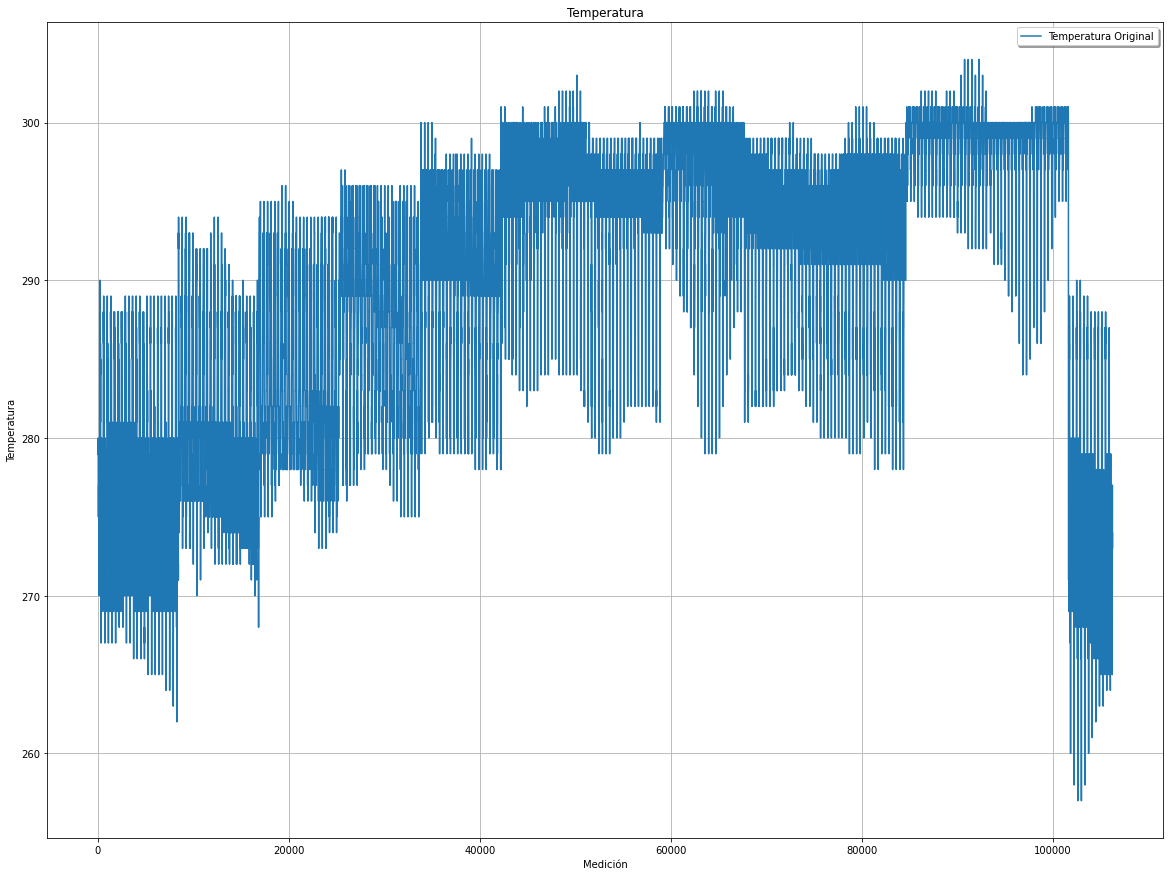

In [9]:
plt.figure(figsize=(20, 15))
plt.plot(x_aux, y_aux, label="Temperatura Original")
plt.title("Temperatura")
plt.xlabel('Medición')
plt.ylabel('Temperatura')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

### Preparación de los datos para el entrenamiento.

Estandarización/Normalización de los datos

In [10]:
#Utilizamos StandarScaler para transformar los datos de manera que su distribución 
#tenga un valor medio 0 y una desviación estándar de 1 para luegro agregarlos a una nueva columna.
sscaler = StandardScaler(withMean = True, withStd = True,
                         inputCol = "FEATURES", 
                         outputCol = "STD_FEATURES")

model = sscaler.fit(vdf)
vdf = model.transform(vdf)
vdf.show(5)

+--------------------+-----+--------------------+
|            FEATURES| TEMP|        STD_FEATURES|
+--------------------+-----+--------------------+
|[35.946552,-100.6...|279.0|[1.37380995529246...|
|[35.945969,-100.4...|280.0|[1.37374271555544...|
|[35.945255,-100.3...|280.0|[1.37366036706106...|
|[35.944454,-100.2...|280.0|[1.37356798450643...|
|[35.943546,-100.1...|280.0|[1.37346326121104...|
+--------------------+-----+--------------------+
only showing top 5 rows



Dividimos nos datos en 70% de entrenamiento y 30 % de prueba

In [11]:
splits = vdf.randomSplit([0.7, 0.3])
train_data = splits[0]
test_data = splits[1]

In [12]:
train_data.describe().show()

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|            74348|
|   mean|290.2273766611072|
| stddev|8.772367557283506|
|    min|            257.0|
|    max|            304.0|
+-------+-----------------+



In [13]:
test_data.describe().show()

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|            31870|
|   mean|290.2470662064638|
| stddev| 8.71931416501957|
|    min|            257.0|
|    max|            304.0|
+-------+-----------------+



### Regresión Lineal 1: Entrenando con datos sin normalizar

In [14]:
regressor1 = LinearRegression(featuresCol = 'FEATURES', labelCol = 'TEMP')

#Learn to fit the model from training set
regressor1 = regressor1.fit(train_data)

#To predict the prices on testing set
pred1 = regressor1.evaluate(test_data)

#Predict the model
#pred1.predictions.show()

22/05/18 17:28:04 WARN Instrumentation: [f0146802] regParam is zero, which might cause numerical instability and overfitting.
22/05/18 17:28:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/18 17:28:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/05/18 17:28:06 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/05/18 17:28:06 WARN Instrumentation: [f0146802] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [15]:
#coefficient of the regression model
coeff1 = regressor1.coefficients
#X and Y intercept
intr1 = regressor1.intercept
print ("The coefficient of the model is:% a"% coeff1)
print ("The intercept of the model is:% f"% intr1)

The coefficient of the model is:DenseVector([0.0076, -0.0004, -0.0009, -0.0, 0.0002, -0.0, 12.3938, 0.6423, 0.3454, -0.0, -0.0032, -0.0011, 0.0, 0.0, -0.0017, -0.001, 0.1209, 0.0, -0.0009, 0.0029, 0.005, 0.0001, 0.0172, 0.0, -0.0058, 0.0, 0.0, 0.0, -0.0298, 0.0001, 0.8945, 0.8945, 0.8945, 2746.1273, 15659.6852, 0.034, -0.543, -0.0039, -0.003, 0.0076, 0.5469, 0.0176, 0.0824, 0.083, 0.0, 0.0, 0.0, -0.0824, 0.0448, -0.003])
The intercept of the model is:-0.525969


In [16]:
eval = RegressionEvaluator(labelCol="TEMP", predictionCol="prediction", metricName="rmse")
# Root Mean Square Error
rmse = eval.evaluate(pred1.predictions)
print("RMSE: %.3f" % rmse)
# Mean Square Error
mse = eval.evaluate(pred1.predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)
# r2 - coefficient of determination
r2 = eval.evaluate(pred1.predictions, {eval.metricName: "r2"})
print("r^2: %.3f" %r2)

/storage/apps/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE: 0.291
MSE: 0.085
r^2: 0.999


 RMSE Mide las diferencias entre los valores predichos por el modelo y los valores reales.
 
 MSE  Mide el error cuadrado promedio, entre las prediccion del modelo y valor real.
 
 r^2 Indica el porcentaje de variabilidad que puesde ser explicado por nuestro modelo

##### Graficando los resultados

In [17]:
vdf1 = pred1.predictions

In [18]:
Comparacion1 = vdf1.select("prediction","TEMP")

In [19]:
Comparacion1.show()

+------------------+-----+
|        prediction| TEMP|
+------------------+-----+
| 280.1958915230627|280.0|
| 287.6499642438958|288.0|
| 287.6100837985919|288.0|
| 287.8661270628936|288.0|
|288.90029115997584|289.0|
|289.10866212689166|289.0|
|281.75445393360127|282.0|
| 279.5741754275734|279.0|
| 288.9291441337486|289.0|
| 287.8766146818401|288.0|
|288.31931386578674|288.0|
|  288.335567335494|288.0|
| 287.5469704963588|288.0|
|287.41933864383327|287.0|
|  287.466632609044|287.0|
| 283.4660600126136|283.0|
| 287.8577422857789|288.0|
|287.89135874397584|288.0|
|282.87301717731214|283.0|
| 287.9234856532293|288.0|
+------------------+-----+
only showing top 20 rows



In [20]:
x_ax1 = range(0, vdf1.count())
y_pred1 = vdf1.select("prediction").collect()
y_orig1 = vdf1.select("TEMP").collect()  

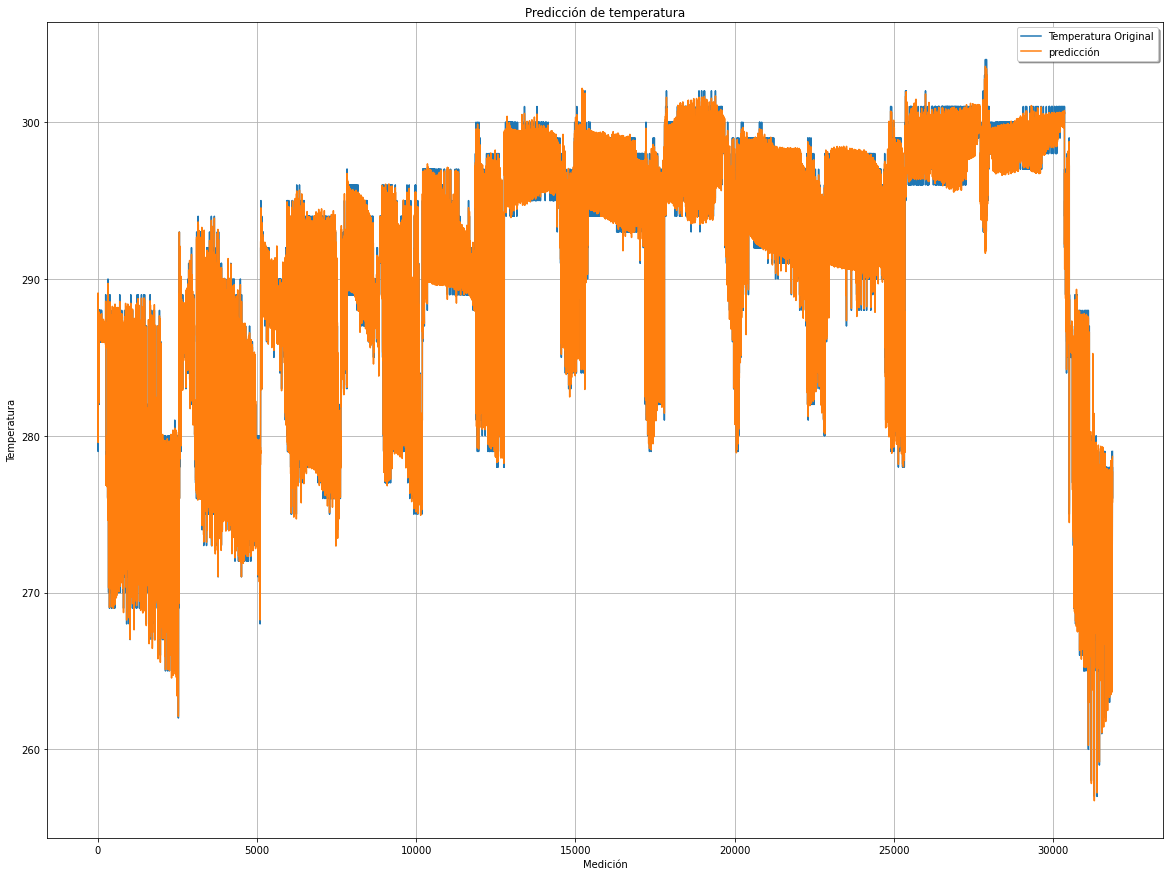

In [21]:
plt.figure(figsize=(20, 15))
plt.plot(x_ax1, y_orig1, label="Temperatura Original")
plt.plot(x_ax1, y_pred1, label="predicción")
plt.title("Predicción de temperatura")
plt.xlabel('Medición')
plt.ylabel('Temperatura')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

### Regresion Lineal 2:  Entrenando con datos normalizados

In [22]:
lr = LinearRegression(featuresCol="STD_FEATURES", labelCol="TEMP", maxIter=1000, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)

print("Coeficientes: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

pred2 = lr_model.evaluate(test_data)

Coeficientes: [0.0,0.0,0.0,0.0,-0.04240619681320538,0.0,0.052849628148780546,7.224150127421198,0.013647474969699227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5830278651139857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.583027865113984]
Intercept: 290.23393716815553


In [23]:
eval = RegressionEvaluator(labelCol="TEMP", predictionCol="prediction", metricName="rmse")
# Root Mean Square Error
rmse = eval.evaluate(pred2.predictions)
print("RMSE: %.3f" % rmse)
# Mean Square Error
mse = eval.evaluate(pred2.predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)
# r2 - coefficient of determination
r2 = eval.evaluate(pred2.predictions, {eval.metricName: "r2"})
print("r^2: %.3f" %r2)

RMSE: 0.462
MSE: 0.214
r^2: 0.997


##### Graficando Resultados

In [24]:
vdf2 = pred2.predictions

In [25]:
Comparacion2 = vdf2.select("prediction","TEMP")

In [26]:
Comparacion2.show()

+------------------+-----+
|        prediction| TEMP|
+------------------+-----+
|281.85619542202267|280.0|
|287.53033850498036|288.0|
| 287.4480066901249|288.0|
|287.65969558312787|288.0|
|288.53569329180954|289.0|
| 288.7209414205177|289.0|
| 283.2677452521867|282.0|
|281.42600289521806|279.0|
| 288.6230438399898|289.0|
| 287.7411504511214|288.0|
|  288.117675800875|288.0|
| 288.1397167967708|288.0|
|287.46265978819616|288.0|
|287.28171118654257|287.0|
|  287.307744856621|287.0|
|284.72737835112724|283.0|
| 287.8654868739443|288.0|
| 287.8902936578257|288.0|
|284.15191499729724|283.0|
| 287.9131324152541|288.0|
+------------------+-----+
only showing top 20 rows



In [27]:
x_ax2 = range(0, vdf2.count())
#x_ax_list = list(x_ax_0)
y_pred2 = vdf2.select("prediction").collect()
y_orig2 = vdf2.select("TEMP").collect()  

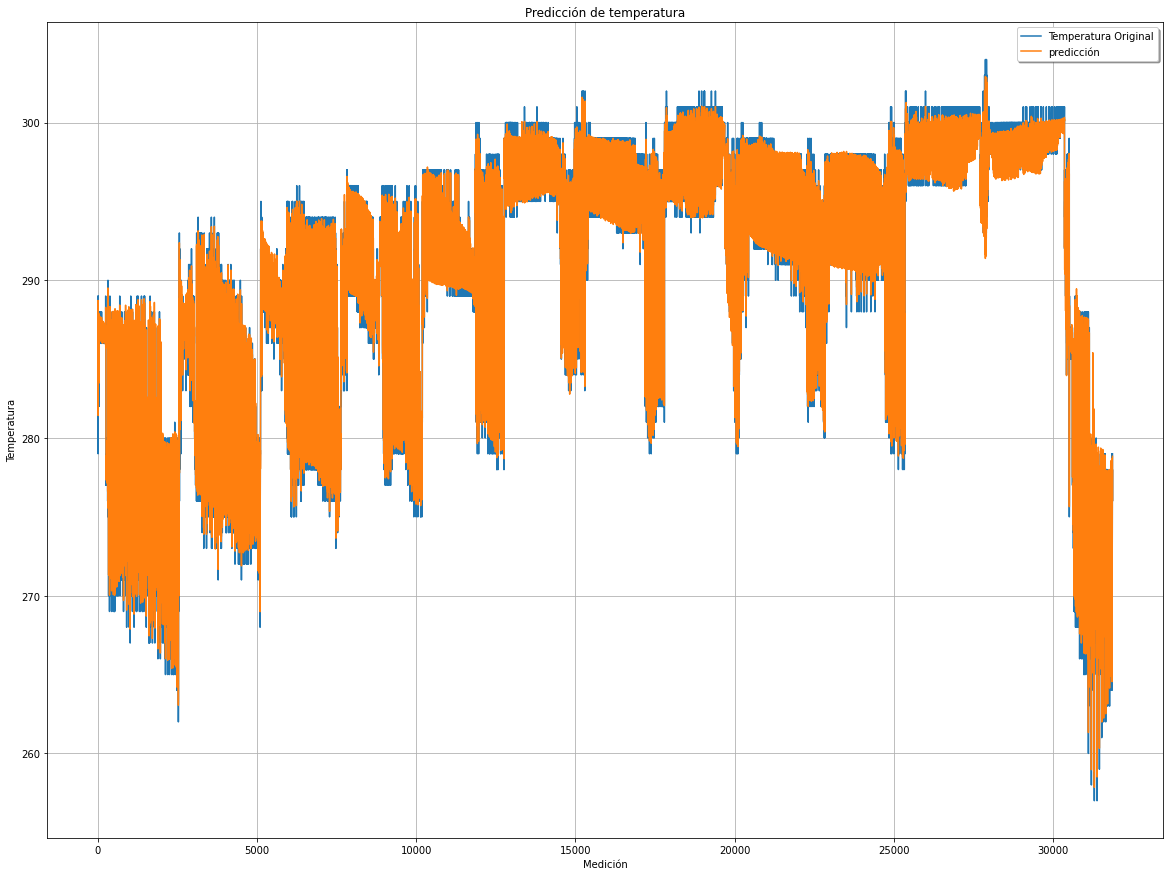

In [28]:
plt.figure(figsize=(20, 15))
plt.plot(x_ax2, y_orig2, label="Temperatura Original")
plt.plot(x_ax2, y_pred2, label="predicción")
plt.title("Predicción de temperatura")
plt.xlabel('Medición')
plt.ylabel('Temperatura')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

### Regresión con Árboles de Decisión - Gradient-boosting

In [34]:
gbm = GBTRegressor(featuresCol = "FEATURES", labelCol = "TEMP", maxIter = 100) 
gbm_model = gbm.fit(train_data)                                                 
gbt_predictions = gbm_model.transform(test_data)                               

In [35]:
gbt_evaluator = RegressionEvaluator(labelCol="TEMP", predictionCol="prediction", metricName="rmse")

rmse = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: 'rmse'})
mae = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: 'mae'})
r2 = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: 'r2'})

print("RMSE = ", rmse)
print("MAE = ", mae)
print("R2 = ", r2)

RMSE =  0.36562405860492025
MAE =  0.2616754858303385
R2 =  0.9982415966366814


In [36]:
vdf3=gbt_predictions

In [37]:
x_ax3 = range(0, vdf3.count())
#x_ax_list = list(x_ax_0)
y_pred3 = vdf3.select("prediction").collect()
y_orig3 = vdf3.select("TEMP").collect()  

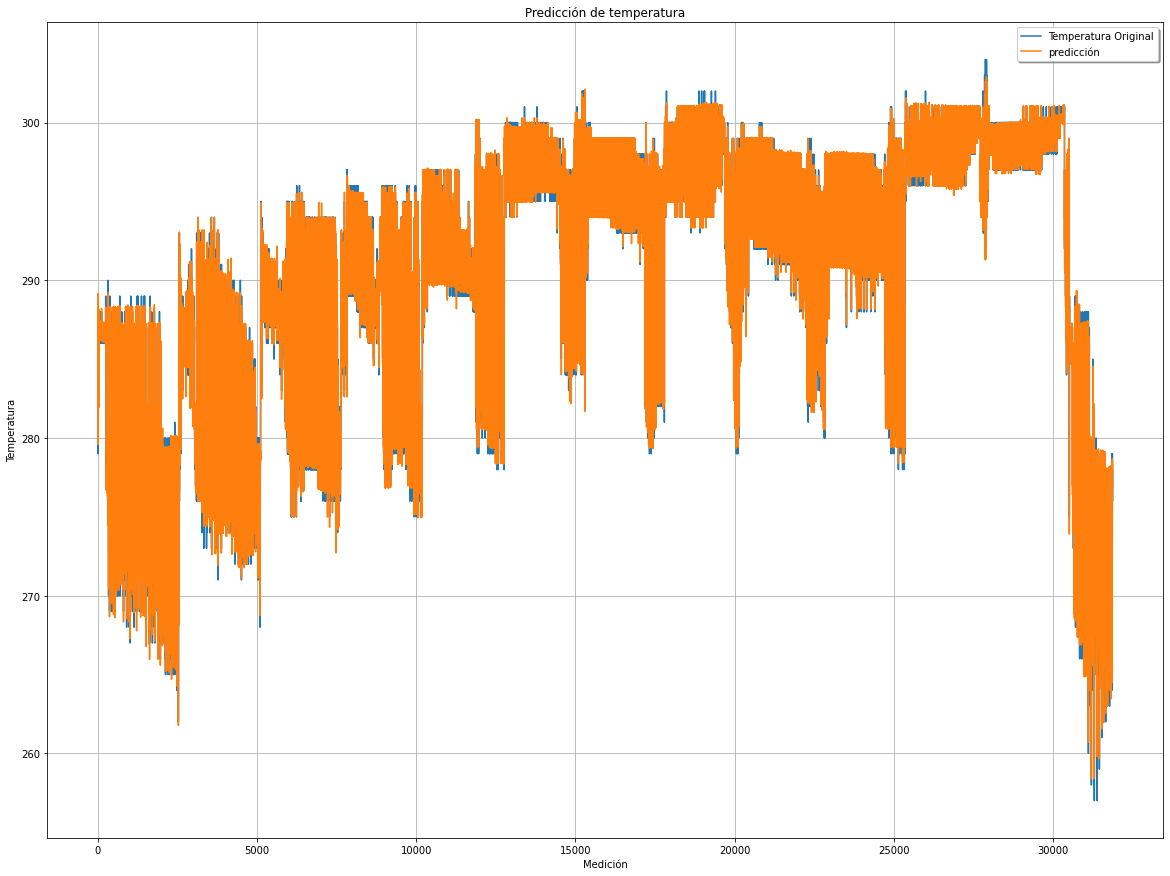

In [38]:
plt.figure(figsize=(20, 15))
plt.plot(x_ax3, y_orig3, label="Temperatura Original")
plt.plot(x_ax3, y_pred3, label="predicción")
plt.title("Predicción de temperatura")
plt.xlabel('Medición')
plt.ylabel('Temperatura')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 